In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from scipy import stats
import warnings

/Users/hdsz/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_train = pd.read_csv('train.csv', index_col=0)
df_train.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,...,mrt_1_5,mrt_closest,distance_to_orchard,month_fe,shopping_mall_1,hawker_1,gold_price,primary_1,primary_2,commercial_1
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,...,1,1.137651,15.791313,8,0.0,1.0,273.00,5.0,9.0,0.0
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,...,2,0.118453,13.378622,10,4.0,0.0,1164.25,8.0,16.0,0.0
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,...,0,0.479542,10.386091,9,2.0,0.0,1886.90,2.0,9.0,0.0
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,...,1,0.421346,7.459592,10,3.0,2.0,264.50,2.0,5.0,0.0
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,...,2,0.775005,11.086004,1,1.0,1.0,1664.75,2.0,9.0,0.0


In [3]:
df_train.shape

(431732, 30)

In [4]:
df_train['storey_range'].unique()


array(['01 to 03', '10 to 12', '07 to 09', '13 to 15', '16 to 18',
       '04 to 06', '22 to 24', '01 to 05', '19 to 21', '11 to 15',
       '06 to 10', '25 to 27', '31 to 33', '28 to 30', '37 to 39',
       '34 to 36', '21 to 25', '16 to 20', '40 to 42', '46 to 48',
       '43 to 45', '26 to 30', '36 to 40', '31 to 35', '49 to 51'],
      dtype=object)

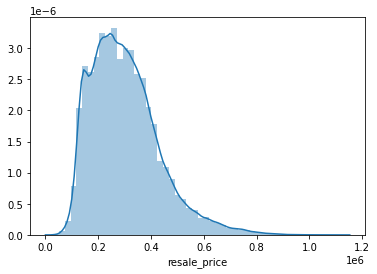

In [5]:
sns.distplot(df_train['resale_price']);


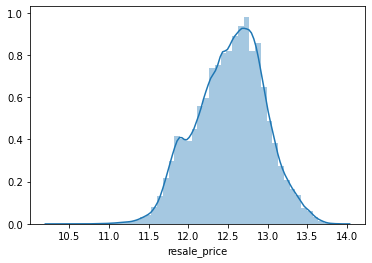

In [6]:
sns.distplot(np.log(df_train['resale_price']))


In [7]:

#skewness and kurtosis
print("Skewness: %f" % df_train['resale_price'].skew())
print("Kurtosis: %f" % df_train['resale_price'].kurt())

Skewness: 0.989732
Kurtosis: 1.411183


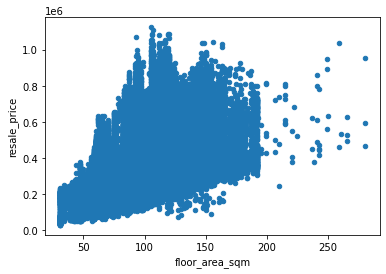

In [8]:
#scatter plot grlivarea/saleprice
var = 'floor_area_sqm'
data = pd.concat([df_train['resale_price'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='resale_price');

In [45]:
def process_df_train(df_train):
    df_train['flat_type'] = df_train['flat_type'].apply(lambda x : x.replace('-', ' ').lower())
    df_train['room_number'] = df_train['flat_type'].map({
        '2 room': 2,
        '3 room': 3,
        '4 room': 4,
        '5 room': 5,
        'executive': 3,
        'multi generation': 4,
        '1 room': 1
    })
    df_train['toilet_number'] = df_train['flat_type'].map({
        '1 room': 1,
        '2 room': 1,
        '3 room': 2,
        '4 room': 2,
        '5 room': 2,
        'executive': 2,
        'multi generation': 3
    })
    df_train['direction'] = df_train['town'].apply(lambda x : town_to_geographical_region[x.upper()])
    df_train['storey_low'] = df_train['storey_range'].apply(lambda x: x.split(" ")[0]).astype('int')
    df_train['storey_high'] = df_train['storey_range'].apply(lambda x: x.split(" ")[2]).astype('int')
    from random import seed
    from random import randint

    seed(42)
    storey_low = [o for o in df_train['storey_low']]
    storey_high = [o for o in df_train['storey_high']]

    df_train.drop('storey_range',axis=1,inplace=True)
    
    df_train['sale_year'] = df_train['month'].apply(lambda x: x.split("-")[0]).astype('int')
    df_train['sale_month'] = df_train['month'].apply(lambda x: x.split("-")[1]).astype('int')
    
    df_train = df_train.drop(['block'],axis=1)
    df_train = df_train.drop(['street_name'],axis=1)
    df_train = df_train.drop(['subzone'],axis=1)
    df_train = df_train.drop(['planning_area'],axis=1)
    df_train = df_train.drop(['month'],axis=1)
    
    return df_train

In [46]:
df_train['flat_type'] = df_train['flat_type'].apply(lambda x : x.replace('-', ' ').lower())

In [47]:
df_train['flat_type'].unique()

array(['1 room', '2 room', '3 room', '4 room', '5 room', 'executive',
       'multi generation'], dtype=object)

In [48]:
df_train['room_number'] = df_train['flat_type'].map({
    '2 room': 2,
    '3 room': 3,
    '4 room': 4,
    '5 room': 5,
    'executive': 3,
    'multi generation': 4,
    '1 room': 1
})

In [49]:
df_train['toilet_number'] = df_train['flat_type'].map({
    '1 room': 1,
    '2 room': 1,
    '3 room': 2,
    '4 room': 2,
    '5 room': 2,
    'executive': 2,
    'multi generation': 3
})

In [50]:
df_train.head()

,town,flat_type,floor_area_sqm,flat_model,eco_category,lease_commence_date,latitude,longitude,elevation,region,...,primary_1,primary_2,commercial_1,room_number,toilet_number,direction,storey_low,storey_high,sale_year,sale_month
7310,bukit merah,1 room,31.0,improved,uncategorized,1975,1.278361,103.819384,0.0,central region,...,3.0,6.0,0.0,1,1,CENTRAL,4,6,2002,3
400182,bukit merah,1 room,31.0,improved,uncategorized,1975,1.278361,103.819384,0.0,central region,...,3.0,6.0,0.0,1,1,CENTRAL,4,6,2017,9
29705,bukit merah,1 room,31.0,improved,uncategorized,1975,1.278361,103.819384,0.0,central region,...,3.0,6.0,0.0,1,1,CENTRAL,10,12,2006,8
131435,bukit merah,1 room,31.0,improved,uncategorized,1975,1.278361,103.819384,0.0,central region,...,3.0,6.0,0.0,1,1,CENTRAL,1,3,2012,8
238173,bukit merah,1 room,31.0,improved,uncategorized,1975,1.278361,103.819384,0.0,central region,...,3.0,6.0,0.0,1,1,CENTRAL,7,9,2014,12


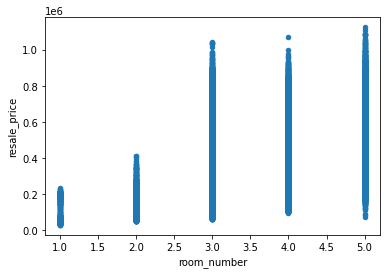

In [51]:
#scatter plot grlivarea/saleprice
var = 'room_number'
data = pd.concat([df_train['resale_price'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='resale_price');

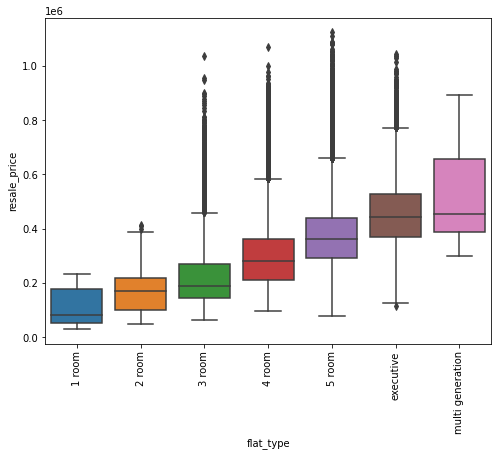

In [52]:
#box plot overallqual/saleprice
var = 'flat_type'
df_train = df_train.sort_values(var)
data = pd.concat([df_train['resale_price'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
plt.xticks(rotation=90)
fig = sns.boxplot(x=var, y="resale_price", data=data)

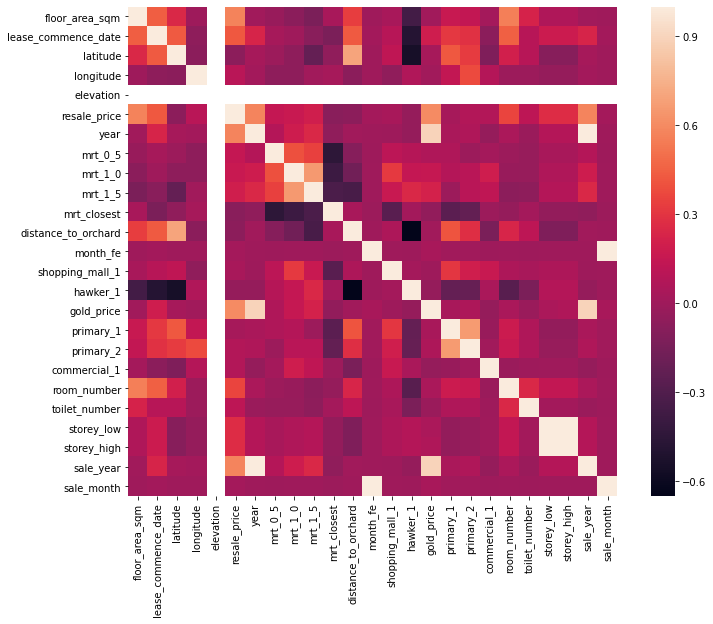

In [53]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat,square=True);

In [54]:
north_east = "NORTH_EAST"
east = "EAST"
west = "WEST"
north = "NORTH"
central = "CENTRAL"
unknow = "UNKNOWN"

town_to_geographical_region  = {
    "ANG MO KIO" : north_east,
    "BEDOK" : east,
    "BISHAN" : central,
    "BUKIT BATOK" : west,
    "BUKIT MERAH" : central,
    "BUKIT PANJANG" : west,
    "BUKIT TIMAH" : central,
    "CENTRAL AREA" : central,
    "CHOA CHU KANG" : west,
    "CLEMENTI" : west,
    "GEYLANG" : central,
    "HOUGANG" : north_east,
    "JURONG EAST" : west,
    "JURONG WEST" : west,
    "KALLANG/WHAMPOA" : central,
    "MARINE PARADE" : central,
    "PASIR RIS" : east,
    "PUNGGOL" : north_east,
    "QUEENSTOWN" : west,
    "SEMBAWANG" : north,
    "SENGKANG" : north_east,
    "SERANGOON" : north_east,
    "TAMPINES" : east,
    "TOA PAYOH" : central,
    "WOODLANDS" : north,
    "YISHUN" : north
}

In [55]:
df_train['direction'] = df_train['town'].apply(lambda x : town_to_geographical_region[x.upper()])


In [56]:

df_train['storey_low'] = df_train['storey_range'].apply(lambda x: x.split(" ")[0]).astype('int')
df_train['storey_high'] = df_train['storey_range'].apply(lambda x: x.split(" ")[2]).astype('int')
from random import seed
from random import randint

seed(42)
storey_low = [o for o in df_train['storey_low']]
storey_high = [o for o in df_train['storey_high']]

df_train.drop('storey_range',axis=1,inplace=True)

KeyError: 'storey_range'

In [ ]:
df_train['sale_year'] = df_train['month'].apply(lambda x: x.split("-")[0]).astype('int')
df_train['sale_month'] = df_train['month'].apply(lambda x: x.split("-")[1]).astype('int')

In [ ]:
df_train.head()

In [ ]:
df_train = df_train.drop(['block'],axis=1)
df_train = df_train.drop(['street_name'],axis=1)
df_train = df_train.drop(['subzone'],axis=1)
df_train = df_train.drop(['planning_area'],axis=1)
df_train = df_train.drop(['month'],axis=1)

In [ ]:
len(df_train)

In [ ]:

from scipy.special import boxcox1p
from scipy.stats import norm, skew #for some statistics

In [ ]:
numeric_feats = df_train.select_dtypes(include=['number']).columns
skew_feats = df_train[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
skew_feats.head(10)

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
x_all = df_train.drop('resale_price',axis=1)
y_all = np.log(df_train['resale_price'])

In [ ]:
x_all = pd.get_dummies(x_all)


In [ ]:
dum_x_train,_,_,_ = train_test_split(df_train,y_all,stratify=df_train['town'],random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_all,y_all, train_size= 400000, stratify=df_train['town'],random_state=42)

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import mlflow
import mlflow.sklearn

In [ ]:

class SklearnModelWithName:
    def __init__(self,model_name,model_definition):
        self.model_name = model_name
        self.model_definition = model_definition

In [ ]:

n_folds = 3

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x_train.values)
    rmse= np.sqrt(-cross_val_score(model, x_train.values, y_train.values, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

def log_result(model_name,model_score,print_result=True):
    if print_result:
        print("{:s}: {:.4f} ({:.4f})\n".format(model_name,model_score.mean(), model_score.std()))
    model_score_mean_name = f"{model_name}_loss_score"
    model_score_std_name = f"{model_name}_std"
    mlflow.log_metric(model_score_mean_name,model_score.mean())
#     mlflow.log_metric(model_score_std_name,model_score.std())

def run_experiment(models,descriptions):
    mlflow.start_run(run_name="HDB Price Prediction")
    for i,o in enumerate(descriptions):
        mlflow.log_param(f"Description {i}",o)
    mlflow.log_param("Train data size", len(x_train))
    for model in models:
        score = rmsle_cv(model.model_definition)
        log_result(model.model_name,score)
    mlflow.end_run()

In [ ]:
elasticnet = make_pipeline(RobustScaler(), ElasticNet(alpha =0.00001, random_state=1))
elasticnet = SklearnModelWithName("elasticnet",elasticnet)

In [ ]:
svm = make_pipeline(RobustScaler(),SVR(C=140))
svm  = SklearnModelWithName("svm",svm)

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso = SklearnModelWithName("lasso",lasso)

In [57]:
GBoost = GradientBoostingRegressor(loss='huber',min_samples_split=10,n_estimators=200)
GBoost = SklearnModelWithName("gboost",GBoost)

In [58]:
extra_tree = ExtraTreesRegressor(n_estimators=100,n_jobs=4,min_samples_split=10)
extra_tree = SklearnModelWithName("extra_tree",extra_tree)

In [59]:
random_forest = RandomForestRegressor(n_estimators=100,n_jobs=4,min_samples_split=10)
random_forest = SklearnModelWithName("random_forest",random_forest)

In [60]:
krr = KernelRidge(alpha=1e-5,kernel='polynomial',degree=3)
krr = SklearnModelWithName("krr",krr)

In [61]:
class StackClassifer(BaseEstimator, TransformerMixin, RegressorMixin):
    def __init__(self,base_models,meta_model):
        self.base_models = base_models
        self.meta_model = meta_model

    def fit_model(self,_model,_x,_y):
        _model.fit(_x,_y)
        return _model
        
    def fit(self,X,y):
        self.base_models_ = clone(self.base_models)
        self.meta_model_ = clone(self.meta_model)
        for base_model in self.base_models_:
            base_model.fit(X,y)
        y_pred = np.array([base_model.predict(X) for base_model in self.base_models_])
        meta_train = y_pred.mean(axis=0,keepdims=True).T
        self.meta_model_.fit(meta_train,y)
        return self
    
    def predict(self,X):
        y_pred = np.array([base_model.predict(X) for base_model in self.base_models_])
        meta_train = y_pred.mean(axis=0,keepdims=True).T
        return self.meta_model_.predict(meta_train)


In [62]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [63]:
test_df = pd.read_csv('test.csv', index_col=0)
test_df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,...,mrt_1_5,mrt_closest,distance_to_orchard,month_fe,shopping_mall_1,hawker_1,gold_price,primary_1,primary_2,commercial_1
0,2004-01,bukit batok,4 room,186,bukit batok west avenue 6,04 to 06,94.0,new generation,uncategorized,1989,...,3,0.667554,10.867610,1,1.0,1.0,399.75,2.0,8.0,0.0
1,2001-11,tampines,5 room,366,tampines street 34,04 to 06,122.0,improved,uncategorized,1997,...,0,0.767026,15.537437,11,0.0,0.0,275.50,2.0,10.0,0.0
2,2002-07,jurong east,3 room,206,jurong east street 21,01 to 03,67.0,new generation,uncategorized,1982,...,2,0.515380,10.704045,7,4.0,1.0,304.65,2.0,6.0,1.0
3,2015-04,ang mo kio,3 room,180,Ang Mo Kio Avenue 5,04 to 06,82.0,new generation,uncategorized,1981,...,2,0.547114,8.603251,4,3.0,3.0,1180.25,2.0,8.0,0.0
4,2004-04,clementi,5 room,356,clementi avenue 2,01 to 03,117.0,standard,uncategorized,1978,...,2,0.516299,7.025758,4,3.0,2.0,388.50,3.0,5.0,0.0


In [64]:
test_df = process_df_train(test_df)
test_df

,town,flat_type,floor_area_sqm,flat_model,eco_category,lease_commence_date,latitude,longitude,elevation,region,...,primary_1,primary_2,commercial_1,room_number,toilet_number,direction,storey_low,storey_high,sale_year,sale_month
0,bukit batok,4 room,94.0,new generation,uncategorized,1989,1.346581,103.744085,0.0,west region,...,2.0,8.0,0.0,4,2,WEST,4,6,2004,1
1,tampines,5 room,122.0,improved,uncategorized,1997,1.357618,103.961379,0.0,east region,...,2.0,10.0,0.0,5,2,EAST,4,6,2001,11
2,jurong east,3 room,67.0,new generation,uncategorized,1982,1.337804,103.741998,0.0,west region,...,2.0,6.0,1.0,3,2,WEST,1,3,2002,7
3,ang mo kio,3 room,82.0,new generation,uncategorized,1981,1.380084,103.849574,0.0,north-east region,...,2.0,8.0,0.0,3,2,NORTH_EAST,4,6,2015,4
4,clementi,5 room,117.0,standard,uncategorized,1978,1.313960,103.769831,0.0,west region,...,3.0,5.0,0.0,5,2,WEST,1,3,2004,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107929,hougang,5 room,110.0,improved,uncategorized,2003,1.380452,103.879333,0.0,north-east region,...,2.0,13.0,0.0,5,2,NORTH_EAST,10,12,2008,4
107930,kallang/whampoa,4 room,102.0,model a,uncategorized,1999,1.314481,103.870458,0.0,central region,...,0.0,8.0,0.0,4,2,CENTRAL,13,15,2006,1
107931,kallang/whampoa,3 room,68.0,improved,uncategorized,1979,1.294924,103.854315,0.0,central region,...,0.0,3.0,2.0,3,2,CENTRAL,7,9,2000,1
107932,jurong west,4 room,104.0,model a,uncategorized,1988,1.339927,103.687354,0.0,west region,...,2.0,7.0,0.0,4,2,WEST,10,12,2009,7


In [65]:
test_df.columns

Index(['town', 'flat_type', 'floor_area_sqm', 'flat_model', 'eco_category',
       'lease_commence_date', 'latitude', 'longitude', 'elevation', 'region',
       'year', 'mrt_0_5', 'mrt_1_0', 'mrt_1_5', 'mrt_closest',
       'distance_to_orchard', 'month_fe', 'shopping_mall_1', 'hawker_1',
       'gold_price', 'primary_1', 'primary_2', 'commercial_1', 'room_number',
       'toilet_number', 'direction', 'storey_low', 'storey_high', 'sale_year',
       'sale_month'],
      dtype='object')

In [66]:
x_test = test_df
x_test = pd.get_dummies(x_test)

In [67]:
x_test.head()

,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,year,mrt_0_5,mrt_1_0,mrt_1_5,mrt_closest,...,region_central region,region_east region,region_north region,region_north-east region,region_west region,direction_CENTRAL,direction_EAST,direction_NORTH,direction_NORTH_EAST,direction_WEST
0,94.0,1989,1.346581,103.744085,0.0,2004,0,1,3,0.667554,...,0,0,0,0,1,0,0,0,0,1
1,122.0,1997,1.357618,103.961379,0.0,2001,0,0,0,0.767026,...,0,1,0,0,0,0,1,0,0,0
2,67.0,1982,1.337804,103.741998,0.0,2002,0,1,2,0.515380,...,0,0,0,0,1,0,0,0,0,1
3,82.0,1981,1.380084,103.849574,0.0,2015,0,1,2,0.547114,...,0,0,0,1,0,0,0,0,1,0
4,117.0,1978,1.313960,103.769831,0.0,2004,0,1,2,0.516299,...,0,0,0,0,1,0,0,0,0,1


In [68]:
x_test.shape

(107934, 88)

In [69]:
x_train = x_train[x_test.columns]
x_train.shape

(400000, 88)

In [70]:
x_train.columns

Index(['floor_area_sqm', 'lease_commence_date', 'latitude', 'longitude',
       'elevation', 'year', 'mrt_0_5', 'mrt_1_0', 'mrt_1_5', 'mrt_closest',
       'distance_to_orchard', 'month_fe', 'shopping_mall_1', 'hawker_1',
       'gold_price', 'primary_1', 'primary_2', 'commercial_1', 'room_number',
       'toilet_number', 'storey_low', 'storey_high', 'sale_year', 'sale_month',
       'town_ang mo kio', 'town_bedok', 'town_bishan', 'town_bukit batok',
       'town_bukit merah', 'town_bukit panjang', 'town_bukit timah',
       'town_central area', 'town_choa chu kang', 'town_clementi',
       'town_geylang', 'town_hougang', 'town_jurong east', 'town_jurong west',
       'town_kallang/whampoa', 'town_marine parade', 'town_pasir ris',
       'town_punggol', 'town_queenstown', 'town_sembawang', 'town_sengkang',
       'town_serangoon', 'town_tampines', 'town_toa payoh', 'town_woodlands',
       'town_yishun', 'flat_type_1 room', 'flat_type_2 room',
       'flat_type_3 room', 'flat_type_4 ro

In [71]:
x_val = x_val[x_test.columns]
x_val.shape

(31732, 88)

In [ ]:
random_forest = make_pipeline(RobustScaler(), RandomForestRegressor(n_estimators=150,n_jobs=4,min_samples_split=10))
random_forest = SklearnModelWithName("random_forest",random_forest)

extra_tree = make_pipeline(RobustScaler(),ExtraTreesRegressor(n_estimators=100,n_jobs=4,min_samples_split=10))
extra_tree = SklearnModelWithName("extra_tree",extra_tree)

mlp = make_pipeline(RobustScaler(), MLPRegressor(hidden_layer_sizes=(80, 80, 50), alpha=0.00001, random_state=1))
mlp = SklearnModelWithName("mlp",mlp)

# gbdt = GradientBoostingRegressor(loss='huber',min_samples_split=10, n_estimators=1000)
# gbdt = SklearnModelWithName("gbdt",gbdt)

base_models_w_name = [mlp, extra_tree, random_forest]
meta_model_w_name = lasso
base_models = [o.model_definition for o in base_models_w_name]
meta_model = meta_model_w_name.model_definition

stack_clf = StackClassifer(base_models,meta_model)
stack_clf.fit(x_train,y_train)

In [ ]:
y_pred = stack_clf.predict(x_val)
rmsle(y_val,y_pred)

In [ ]:
y_test = stack_clf.predict(x_test)
y_test = np.exp(y_test)
y_test

In [ ]:
submission_df = pd.DataFrame(y_test)
submission_df['Id'] = submission_df.index
submission_df['Predicted'] = submission_df[0]
del submission_df[0]
submission_df.head()

In [ ]:
submission_df.to_csv('submission.csv', index=False)